In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

read_smaller_states = True

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {'CO': {},
                     'MD': {},
                     'MN': {},
                     'MO': {},
                     'WI': {},
            }

g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
desired_pct_area_overlap = 0.5

show_water = True
show_roads = False
water_area_tol = .5 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))



looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 5 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


# Read redistricting geo data

In [8]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading cogeo2020.pl...
	reading mdgeo2020.pl...
	reading mngeo2020.pl...
	reading mogeo2020.pl...
	reading wigeo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 1,390,560 geographies in 1 minutes 10 seconds!


In [9]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.2 seconds!


In [10]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 39 congressional districts to shapefiles in 8.4 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    #print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for CO...
	getting shapefiles for MD...
	getting shapefiles for MN...
	getting shapefiles for MO...
	getting shapefiles for WI...


Joined 7,623 tracts to shapefiles in 13.7 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
#this_state = 'WI'

state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
#     if (this_state in thisrow['NAME']):
#         print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


#cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)


getting states...
getting counties...
Got 56 states and 3,234 counties in 5.9 seconds!


getting water areas...
	reading water file 0 of 362...
	reading water file 10 of 362...
	reading water file 20 of 362...
	reading water file 30 of 362...
	reading water file 40 of 362...
	reading water file 50 of 362...
	reading water file 60 of 362...
	reading water file 70 of 362...
	reading water file 80 of 362...
	reading water file 90 of 362...
	reading water file 100 of 362...
	reading water file 110 of 362...
	reading water file 120 of 362...
	reading water file 130 of 362...
	reading water file 140 of 362...
	reading water file 150 of 362...
	reading water file 160 of 362...
	reading water file 170 of 362...
	reading water file 180 of 362...
	reading water file 190 of 362...
	reading water file 200 of 362...
	reading water file 210 of 362...
	reading water file 220 of 362...
	reading water file 230 of 362...
	reading water file 240 of 362...
	reading water file 250 of 362...
	reading water 

In [14]:

# print('getting CBSAs (metro areas)...')
# cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
# cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
# cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
# cbsa_gdf = cbsa_gdf.set_index('GEOID')

# print('Finding populations of CBSAs...')
# cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
# for ix, thisrow in cbsa_gdf.iterrows():
#     if ('ID' in thisrow['NAME']):
#         print('\t{0:}...'.format(thisrow['NAME']))
#     cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
# cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan



# cbsa_gdf[(cbsa_gdf['NAME'].apply(lambda x: 'ID' in x)) & (cbsa_gdf['POP100'].isnull())]
# tract_gdf['COUNTYNS']

In [15]:

# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
		Plotting MN...
		Plotting MD...
		Plotting WI...
		Plotting CO...
		Plotting MO...
	plotting census tracts...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...
Done plotting in 55 seconds!


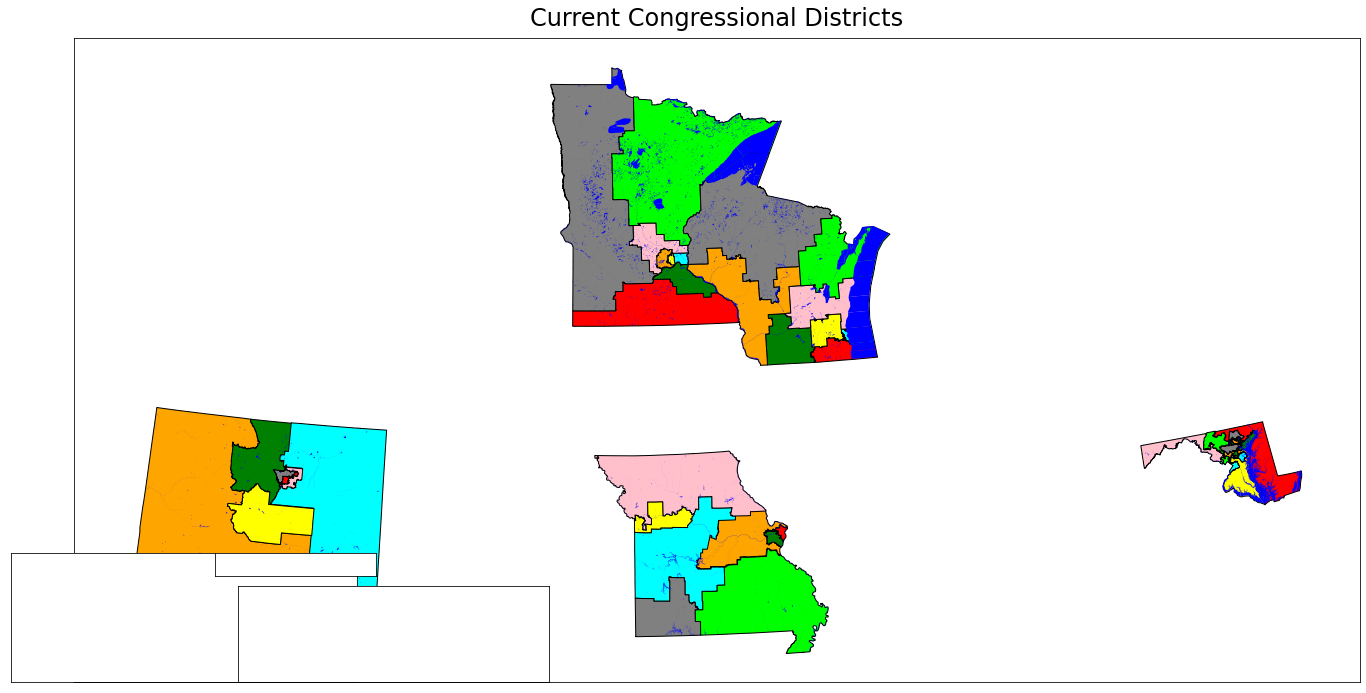

In [16]:
s = time.time()
# main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
# alaska_crs = "epsg:3338"
# hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = True

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].tolist():#.sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
#         annotator = i
#         this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
#         centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
# #ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

# print('saving figure...')
# fig.savefig(script_dir+'all-districts-orig.jpg', format='jpg', dpi=300, bbox_inches='tight')
#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:,.0f} seconds!'.format(e-s))

# How many districts in each state?

In [17]:

for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
    
these_states_dict
#water_gdf.head(1).T

{'CO': {'STATEFP': 8, 'seats_old': 7, 'seats_new': 8, 'target': 721714.25},
 'MD': {'STATEFP': 24, 'seats_old': 8, 'seats_new': 8, 'target': 772153.0},
 'MN': {'STATEFP': 27, 'seats_old': 8, 'seats_new': 8, 'target': 713311.75},
 'MO': {'STATEFP': 29, 'seats_old': 8, 'seats_new': 8, 'target': 769364.125},
 'WI': {'STATEFP': 55, 'seats_old': 8, 'seats_new': 8, 'target': 736714.75}}

# COLORADO

In [18]:
s = time.time()
this_state = 'CO'

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Denver County',1], 
    
    
['Gilpin County',3], 
    ['Clear Creek County',3], 
    ['Jackson County',3], 
    ['Grand County',3], 
    ['Summit County',3], 
    ['Eagle County',3], 
    ['Routt County',3], 
    ['Rio Blanco County',3], 
    ['Moffat County',3],
    ['Garfield County',3], 
    ['Mesa County',3], 
    ['Delta County',3], 
    ['Pitkin County',3], 
    ['Lake County',3], 
    ['Park County',3], 
    ['Teller County',3],
    ['Montrose County',3], 
    ['Gunnison County',3], 
    ['Chaffee County',3], 
    ['San Miguel County',3], 
    ['Ouray County',3], 
    ['San Juan County',3], 
    ['Montezuma County',3], 
    ['La Plata County',3],
    ['Hinsdale County',3], 
    ['Mineral County',3], 
    ['Archuleta County',3], 
    ['Saguache County',3], 
    ['Rio Grande County',3], 
    ['Conejos County',3], 
    ['Dolores County',3],
    
    
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[

['Englewood',6], 
    ['Cherry Hills Village',6], 
    ['Greenwood Village',6], 
    ['Cherry Creek',6], 
    ['Centennial',6], 
    ['Inverness',6], 
    ['Dove Valley',6],
    ['Foxfield',6], 
    ['Ken Caryl',6], 
    ['Columbine',6], 
    ['Columbine Valley',6], 
    ['Littleton',6], 
    ['Sterling Ranch',6], 
    ['Highlands Ranch',6],
    ['Acres Green',6], 
    ['Lone Tree',6], 
    ['Meridian',6], 
    ['Grand View Estates',6], 
    ['Stonegate',6], 
    ['Sheridan',6], 
    ['Grand View Estates',6],
    ['Dakota Ridge',6], 
    ['Bow Mar',6], 
    ['Sierra Ridge',6], 
    ['Stepping Stone',6], 
    ['Meridian Village',6], 
    ['Parker',6],
    
    
    
['Lakewood',7], 
    ['Edgewater',7], 
    ['Wheat Ridge',7], 
    ['Lakeside',7], 
    ['Arvada',7], 
    ['Fairmount',7], 
    ['Mountain View',7], 
    ['Applewood',7], 
    ['East Pleasant View',7], 
    ['West Pleasant View',7],
    ['Golden',7], 
    ['Westminster',7], 
    ['Berkley',7], 
    ['North Washington',7], 
    ['Twin Lakes',7], 
    ['Sherrelwood',7], 
    ['Welby',7], 
    ['Federal Heights',7], 
    ['Northglenn',7], 


    
['Lafayette',8],
    ['Louisville',8], 
    ['Superior',8],
    ['Roxborough Park',8], 
    ['Castle Pines',8], 
    ['Castle Pines Village',8], 
    ['Castle Rock',8], 
    ['The Pinery',8], 
    ['Ponderosa Park',8], 
    ['Elizabeth',8],
    ['Aurora',8],
    ['Bennett',8],
    ['Aetna Estates',8],
    ['Thornton',8],    
    
    
    
['Colorado Springs',5], 
    ['Air Force Academy',5], 
    ['Cimarron Hills',5], 
    ['Woodmoor',5], 
    ['Monument',5], 
    ['Gleneagle',5], 
    ['Palmer Lake',5],
    
    ['Black Forest',5], 
    ['Stratmoor',5], 
    ['Security-Widefield',5], 
    ['Fort Carson',5], 
    ['Fountain',5], 
    ['Rock Creek Park',5], 
    ['Manitou Springs',5],
    ['Cascade-Chipita Park',5],
    
    
    
    
['Boulder',2], 
    ['Erie',2], 
    ['Gunbarrel',2], 
    ['Valmont',2], 
    ['Leyner',2], 
    ['Longmont',2],
    ['Frederick',2], 
    ['Firestone',2], 
    ['Mead',2], 
    ['Windsor',2], 
    ['Fort Collins',2], 
    ['Loveland',2], 
    
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US08005004951', '1400000US08005004952', '1400000US08005015100'], 'new_district'] = 1



tract_gdf.loc[['1400000US08059012050', '1400000US08059012054', '1400000US08005085300', '1400000US08005085600', '1400000US08005085700'], 'new_district'] = 6
tract_gdf.loc[['1400000US08035014014', '1400000US08005086500', '1400000US08005086600', '1400000US08005085100', '1400000US08005006862', '1400000US08005980000', '1400000US08035013912'], 'new_district'] = 6
tract_gdf.loc[['1400000US08035014011', '1400000US08035014125', '1400000US08035014144'], 'new_district'] = 6
tract_gdf.loc[['1400000US08005086801', '1400000US08005086802', '1400000US08005086900', '1400000US08005087000', '1400000US08005087100', '1400000US08005087200', '1400000US08005087301', '1400000US08005087302'], 'new_district'] = 6
tract_gdf.loc[['1400000US08001007801', '1400000US08001007802', '1400000US08001007900', '1400000US08001008000'], 'new_district'] = 6
tract_gdf.loc[['1400000US08005007201', '1400000US08005007202', '1400000US08005007301', '1400000US08005007302', '1400000US08005007400', '1400000US08005007702', '1400000US08005007703', '1400000US08005007704'], 'new_district'] = 6
tract_gdf.loc[['1400000US08005080000', '1400000US08005080100', '1400000US08005080200', '1400000US08005080300', '1400000US08005080400', '1400000US08005080500', '1400000US08005080600', '1400000US08005080700', '1400000US08005080800', '1400000US08005080900'], 'new_district'] = 6
tract_gdf.loc[['1400000US08001008100', '1400000US08005007500', '1400000US08005007600', '1400000US08005081500'], 'new_district'] = 6




tract_gdf.loc[['1400000US08059009854', '1400000US08059009857', '1400000US08059011709', '1400000US08059011721', '1400000US08059015900', '1400000US08014031103', '1400000US08059980400', '1400000US08059980800'], 'new_district'] = 7
tract_gdf.loc[['1400000US08001009202', '1400000US08001009203', '1400000US08001009204', '1400000US08001009206', '1400000US08001009207', '1400000US08001009316', '1400000US08001009318', '1400000US08001009322', '1400000US08001009407'], 'new_district'] = 7
tract_gdf.loc[['1400000US08001008705', '1400000US08001008706', '1400000US08001008709', '1400000US08001008801', '1400000US08001008802', '1400000US08001008901', '1400000US08001009101', '1400000US08001009104'], 'new_district'] = 7
tract_gdf.loc[['1400000US08001008558', '1400000US08001008559', '1400000US08001988700'], 'new_district'] = 7
tract_gdf.loc[['1400000US08001008538'], 'new_district'] = 7



tract_gdf.loc[['1400000US08014031300', '1400000US08014030500','1400000US08014030600', '1400000US08014030700', '1400000US08014030800', '1400000US08014031000'], 'new_district'] = 8
tract_gdf.loc[['1400000US08014030000', '1400000US08014030100', '1400000US08014030200', '1400000US08014030300', '1400000US08014030400', '1400000US08014030900', '1400000US08014031101'], 'new_district'] = 8
tract_gdf.loc[['1400000US08013060801', '1400000US08014031102', '1400000US08014031104', '1400000US08014031201', '1400000US08014031202', '1400000US08014980100', '1400000US08014980200', '1400000US08014980300'], 'new_district'] = 8
tract_gdf.loc[['1400000US08013060602', '1400000US08059980700', '1400000US08013012510', '1400000US08059009858'], 'new_district'] = 8
tract_gdf.loc[['1400000US08059009845', '1400000US08059009846', '1400000US08059009847', '1400000US08059009848', '1400000US08059009850', '1400000US08059012026', '1400000US08059012027'], 'new_district'] = 8
tract_gdf.loc[['1400000US08059012030', '1400000US08059012031', '1400000US08059012032', '1400000US08059012033', '1400000US08059012034', '1400000US08059012035', '1400000US08059012036', '1400000US08059012037'], 'new_district'] = 8
tract_gdf.loc[['1400000US08005007113','1400000US08005086700','1400000US08035013909', '1400000US08035013911','1400000US08035013913','1400000US08035013914', '1400000US08035014016','1400000US08035014017','1400000US08035014135'], 'new_district'] = 8
tract_gdf.loc[['1400000US08035014205', '1400000US08035014206', '1400000US08035014208', '1400000US08035014407', '1400000US08035014409', '1400000US08035014505', '1400000US08035014604'], 'new_district'] = 8
tract_gdf.loc[['1400000US08005007109', '1400000US08005007111', '1400000US08005083201', '1400000US08005083202', '1400000US08005085900', '1400000US08005086001', '1400000US08005086002'], 'new_district'] = 8
tract_gdf.loc[['1400000US08005007103', '1400000US08005007106', '1400000US08039961204', '1400000US08001008401', '1400000US08001008553', '1400000US08001060001'], 'new_district'] = 8
tract_gdf.loc[['1400000US08001008535', '1400000US08001008536', '1400000US08001008549', '1400000US08001008551', '1400000US08001008552', '1400000US08001008556', '1400000US08001008557'], 'new_district'] = 8





tract_gdf.loc[['1400000US08041003712', '1400000US08041003802', '1400000US08041007204', '1400000US08041007302', '1400000US08041007402', '1400000US08041004515', '1400000US08041004516', '1400000US08041004517', '1400000US08041005115', '1400000US08041007603'], 'new_district'] = 5
tract_gdf.loc[['1400000US08041003306', '1400000US08041003401', '1400000US08041003713', '1400000US08041003910', '1400000US08041003911', '1400000US08041003912', '1400000US08041003914', '1400000US08041005123', '1400000US08041004403', '1400000US08041006702', '1400000US08041004601'], 'new_district'] = 5
    
    
    

tract_gdf.loc[['1400000US08014031401', '1400000US08014031402', '1400000US08014031403'], 'new_district'] = 2
tract_gdf.loc[['1400000US08001008560', '1400000US08001008561', '1400000US08001008562', '1400000US08001008563', '1400000US08001008564', '1400000US08001008565', '1400000US08001008603', '1400000US08001008604', '1400000US08001008605', '1400000US08001008606'], 'new_district'] = 2
tract_gdf.loc[['1400000US08013012201', '1400000US08013012505', '1400000US08013012508', '1400000US08013012701', '1400000US08013012707', '1400000US08013012801', '1400000US08013012802', '1400000US08013012907', '1400000US08013013003', '1400000US08013013201', '1400000US08013013205', '1400000US08013013207', '1400000US08013013211', '1400000US08013013214'], 'new_district'] = 2
tract_gdf.loc[['1400000US08123001404', '1400000US08123002101', '1400000US08123002104', '1400000US08123002106', '1400000US08123002107', '1400000US08123002108', '1400000US08123002010', '1400000US08123002021'], 'new_district'] = 2
tract_gdf.loc[['1400000US08013012710', '1400000US08069002602', '1400000US08069002700', '1400000US08069001713', '1400000US08069002011', '1400000US08069001608', '1400000US08069001712', '1400000US08069001813'], 'new_district'] = 2
tract_gdf.loc[['1400000US08123001905', '1400000US08123001909', '1400000US08123001910', '1400000US08123001911', '1400000US08123001912', '1400000US08123002004', '1400000US08123002005', '1400000US08123002006'], 'new_district'] = 2
tract_gdf.loc[['1400000US08123002207', '1400000US08123002209', '1400000US08069002505'], 'new_district'] = 2




tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Boulder County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3



print('All the rest are district 4...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 4


# print('Except ocean tracts...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')

getting from backup...
Assigning districts by county...
Assigning districts by place...


Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
	Tracts within District 2: 51...
	Tracts intersecting (but not within) District 2: 113...
		Examining tract 1 of 113...
		Examining tract 51 of 113...
		Examining tract 101 of 113...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
Looking for tracts related to places in District 5...
	Tracts within District 5: 107...
	Tracts intersecting (but not within) District 5: 62...
		Examining tract 1 of 62...
		Examining tract 51 of 62...
Looking for tracts related to places in District 6...
	Tracts within District 6: 83...
	Tracts intersecting (but not within) District 6: 74...
		Examining tract 1 of 74...
		Examining tract 51 of 74...
Looking for tracts related to places in District 7...
	Tracts within District 7: 78...
	Tracts intersectin

# MARYLAND

In [19]:
s = time.time()
maryland_df = pandas.read_csv(script_dir+'maryland.csv', index_col='GEOID')
tract_gdf.loc[tract_gdf['STUSAB'] == 'MD', 'new_district'] = maryland_df['new_district']
e = time.time()
g += (e-s)
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))


Assigned districts to 7,623 tracts in 0 minutes 0 seconds!


# MINNESOTA

In [20]:
s = time.time()
this_state = 'MN'
examine_duplicates = False

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Ramsey County',4], 

    
['Le Sueur County',2], 
    ['Rice County',2], 
    ['Goodhue County',2],
    ['Wabasha County',2],

    
['Cook County',8], 
    ['Lake County',8], 
    ['St. Louis County',8], 
    ['Koochiching County',8], 
    ['Itasca County',8], 
    ['Cass County',8], 
    ['Carlton County',8],
    ['Crow Wing County',8], 
    ['Aitkin County',8], 
    ['Pine County',8],
    ['Mille Lacs County',8],
    ['Kanabec County',8],
    ['Isanti County',8],
    ['Chisago County',8],


    
['Winona County',1], 
    ['Olmsted County',1], 
    ['Fillmore County',1], 
    ['Dodge County',1], 
    ['Mower County',1], 
    ['Waseca County',1], 
    ['Freeborn County',1], 
    ['Steele County',1], 
    ['Faribault County',1], 
    ['Blue Earth County',1],
    ['Brown County',1], 
    ['Watonwan County',1], 
    ['Martin County',1], 
    ['Jackson County',1], 
    ['Cottonwood County',1], 
    ['Murray County',1], 
    ['Nobles County',1],
    ['Pipestone County',1], 
    ['Rock County',1], 
    ['Houston County',1],    
    ['Nicollet County',1],
    ['Sibley County',1],
    ['McLeod County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[

['Minneapolis',5], 
    ['Richfield',5], 
    ['Edina',5], 
    ['St. Louis Park',5], 
    ['Golden Valley',5], 
    ['New Hope',5], 
    ['Crystal',5], 
    ['Robbinsdale',5],
    ['Brooklyn Center',5], 
    ['Hopkins',5], 
    ['St. Anthony',5], 

    
['Brooklyn Park',3], 
    ['Osseo',3],
    ['Bloomington',3], 
    ['Eden Prairie',3], 
    ['Minnetonka',3],
    ['Wayzata',3], 
    ['Woodland',3], 
    ['Deephaven',3], 
    ['Plymouth',3],
    ['Maple Grove',3],
    ['Champlin',3],
    ['Spring Park',3], 
    ['Minnetonka Beach',3], 
    ['Tonka Bay',3], 
    ['Greenwood',3], 
    ['Shorewood',3], 
    ['Chanhassen',3], 
    ['Chaska',3], 
    ['Shakopee',3],
    ['Prior Lake',3], 
    ['Savage',3],
    ['Burnsville',3],

    
    
['Columbia Heights',4],
    ['Fridley',4], 
    ['Spring Lake Park',4], 
    ['Mendota Heights',4],
    ['West St. Paul',4], 
    ['South St. Paul',4], 
    ['Sunfish Lake',4], 
    ['Mahtomedi',4], 
    ['Pine Springs',4], 
    ['Dellwood',4], 
    ['Birchwood Village',4], 
    ['Willernie',4],
    ['Landfall',4],
    ['Oakdale',4],
    ['Newport',4],

    
    
['St. Paul Park',2], 
    ['Cottage Grove',2], 
    ['Woodbury',2], 
    ['Lakeland',2], 
    ['Lakeland Shores',2], 
    ['St. Marys Point',2], 
    ['Lake St. Croix Beach',2],
    ['Lake Elmo',2], 
    ['Oak Park Heights',2], 
    ['Bayport',2], 
    ['Grant',2], 
    ['Stillwater',2], 
    
    
['Elk River',6], 
    ['Otsego',6], 
    ['Monticello',6], 
    ['St. Michael',6],
    ['Hanover',6],
    ['Buffalo',6],
    ['St. Cloud',6],
    ['St. Joseph',6], 
    ['St. Augusta',6], 
    ['Rockville',6], 
    ['Sauk Rapids',6], 
    ['Sartell',6],    
    ['Victoria',6], 
    
    
['Little Falls',8],

], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


this_state_places = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]

if (len(this_state_places[
    (this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist())) 
    & (this_state_places['NAME'].duplicated() == True)]) > 0):
    print('DANGER: list of selected places includes duplicate place names:')
    print('\n')
    duplicated_name_list = this_state_places[(this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist()))  & (this_state_places['NAME'].duplicated() == True)]['NAME'].tolist()
    for this_duplicated_name in duplicated_name_list:
        print('----- {0:} -----'.format(this_duplicated_name))
        if (examine_duplicates):
            all_duplicated_tracts_to_show = []
            for ix, thisrow in this_state_places[(this_state_places['NAME'] == this_duplicated_name)].iterrows():
                print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))
                included_tracts = []
                for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
                    print('\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
                    for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
                        this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
                        this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
                        this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
                        if (this_tract_intersection_pct >= desired_pct_area_overlap):
                            print('\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
                            included_tracts.append(kx)
                print('\t\t{0:} (GEOID = {1:}) includes {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAMELSAD'], ix, len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
                print('\n')

                all_duplicated_tracts_to_show += included_tracts
            tract_gdf[tract_gdf.index.isin(all_duplicated_tracts_to_show)].plot()

#print('\n')
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicate_place_names_list)].index, axis=0)
print('Selecting the correct place from the duplicates...')
print('\t{0:} (GEOID == {1:})'.format('St. Anthony (Minneapolis area)', '1600000US2756680'))
place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'St. Anthony') & (place_mapper_gdf.index != '1600000US2756680')].index, axis=0)
print('\n')



#print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US27053980000', '1400000US27053980100'], 'new_district'] = 3


tract_gdf.loc[['1400000US27163070705', '1400000US27163070706', '1400000US27163071102', '1400000US27163070404'], 'new_district'] = 2


tract_gdf.loc[['1400000US27141030301', '1400000US27141030302', '1400000US27141030405', '1400000US27141030406', '1400000US27141030407', '1400000US27141030409', '1400000US27141030410', '1400000US27141031500'], 'new_district'] = 6
tract_gdf.loc[['1400000US27171100202', '1400000US27171100203', '1400000US27171100205', '1400000US27171100300', '1400000US27171100401', '1400000US27171100402', '1400000US27171100706', '1400000US27171100707'], 'new_district'] = 6
tract_gdf.loc[['1400000US27145000501', '1400000US27145000502', '1400000US27145010101', '1400000US27145011202', '1400000US27009020206'], 'new_district'] = 6
tract_gdf.loc[['1400000US27171100900', '1400000US27171101001', '1400000US27171101002', '1400000US27019090101', '1400000US27019090102', '1400000US27019090302', '1400000US27019090303', '1400000US27019090304', '1400000US27019090401'], 'new_district'] = 6


tract_gdf.loc[['1400000US27097780300', '1400000US27097780400', '1400000US27097780500'], 'new_district'] = 8



####### Rest of Dakota and Scott Counties are District 2
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Dakota County', 'Scott County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2


####### Rest of Hennepin and Anoka Counties are District 6
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Hennepin County', 'Anoka County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 6


####### Rest of Benton, Sherburne, and Washington County is District 8
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Benton County', 'Sherburne County', 'Washington County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 8


####### Rest of Carver County is District 1
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Carver County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 1



print('All the rest are district 7...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 7


print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan


e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')


getting from backup...
Assigning districts by county...
Assigning districts by place...
DANGER: list of selected places includes duplicate place names:


----- St. Anthony -----
Selecting the correct place from the duplicates...
	St. Anthony (Minneapolis area) (GEOID == 1600000US2756680)


Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
	Tracts within District 2: 28...
	Tracts intersecting (but not within) District 2: 25...
		Examining tract 1 of 25...
Looking for tracts related to places in District 3...
	Tracts within District 3: 157...
	Tracts intersecting (but not within) District 3: 70...
		Examining tract 1 of 70...
		Examining tract 51 of 70...
Looking for tracts related to places in District 4...
	Tracts within District 4: 34...
	Tracts intersecting (but not within) District 4: 27...
		Examining tract 1 of 27...
Looking for tracts related to places in District 5...
	Tracts within District 5: 198...
	Tracts intersecting

# MISSOURI

In [21]:
s = time.time()
this_state = 'MO'
examine_duplicates = False

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Lincoln County',3],
    ['Warren County',3],
    ['Franklin County',3],
    ['Washington County',3],
    ['Gasconade County',3],
    ['Crawford County',3],
    ['Montgomery County',3],
    ['Ste. Genevieve County',3],
    ['St. Francois County',3],
    ['Perry County',3],
    
    
['Jackson County',5],


    
['Clay County',4],
    ['Platte County',4],
    ['Lafayette County',4],
    ['Ray County',4],
    ['Clinton County',4],
    ['Bates County',4],
    ['Caldwell County',4],
    ['Johnson County',4],
    ['Henry County',4],
    ['Buchanan County',4],
    ['Vernon County',4],
    ['St. Clair County',4],
    ['Andrew County',4],
    ['DeKalb County',4],
    ['Daviess County',4],
    ['Holt County',4],
    ['Cedar County',4],

    
['Greene County',7],
    ['Christian County',7],
    ['Polk County',7],
    ['Barton County',7],
    ['Dade County',7],
    ['Jasper County',7],
    ['Lawrence County',7],
    ['Newton County',7],
    ['McDonald County',7],
    ['Barry County',7],
    ['Stone County',7],
    
    
['Cape Girardeau County',8],
    ['Mississippi County',8],
    ['Scott County',8],
    ['New Madrid County',8],
    ['Pemiscot County',8],
    ['Stoddard County',8],
    ['Dunklin County',8],
    ['Butler County',8],
    ['Bollinger County',8],
    ['Wayne County',8],
    ['Madison County',8],
    ['Iron County',8],
    ['Reynolds County',8],
    ['Dent County',8],
    ['Shannon County',8],
    ['Ripley County',8],
    ['Oregon County',8],
    ['Carter County',8],
    ['Phelps County',8],
    ['Texas County',8],
    ['Howell County',8],
    ['Douglas County',8],
    ['Ozark County',8],
    ['Taney County',8],
    ['Wright County',8],
   ['Hickory County',8],
    ['Laclede County',8],
    ['Pulaski County',8],
   ['Camden County',8],
    ['Miller County',8],
    ['Maries County',8],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Glasgow Village',1], 
    ['Bellefontaine Neighbors',1], 
    ['Riverview',1], 
    ['Castle Point',1], 
    ['Moline Acres',1],
    ['Dellwood',1], 
    ['Ferguson',1], 
    ['Country Club Hills',1],
    ['Flordell Hills',1], 
    ['Jennings',1], 
    ['Pine Lawn',1], 
    ['Northwoods',1], 
    ['Beverly Hills',1], 
    ['Velda City',1], 
    ['Uplands Park',1], 
    ['Hillsdale',1], 
    ['Wellston',1],
    ['Pasadena Park',1], 
    ['Velda Village Hills',1], 
    ['Glen Echo Park',1], 
    ['Pasadena Hills',1], 
    ['Normandy',1], 
    ['Bellerive Acres',1],
    ['Bel-Nor',1], 
    ['Greendale',1], 
    ['Bel-Ridge',1], 
    ['St. John',1], 
    ['Pagedale', 1], 
    ['Hanley Hills',1], 
    ['Vinita Park',1], 
    ['Charlack',1],
    ['Sycamore Hills',1], 
    ['Overland',1],
    ['Breckenridge Hills',1],
    ['Woodson Terrace',1],
    ['Berkeley',1], 
    ['St. Ann',1], 
    ['Kinloch',1], 
    ['Olivette',1], 
    ['University City',1], 
    ['Clayton',1],
    ['Ladue',1], 
    ['Richmond Heights',1], 
    ['Brentwood',1], 
    ['Maplewood',1], 
    ['Rock Hill',1], 
    ['Warson Woods',1], 
    ['Glendale',1],
    ['Oakland',1], 
    ['Shrewsbury',1], 
    ['Webster Groves',1], 
    ['Marlborough',1],
    ['Crestwood',1], 
    ['Grantwood Village',1], 
    ['Affton',1], 
    ['Wilbur Park',1], 
    ['Bella Villa',1], 
    ['Lemay',1], 
    ['St. George',1],
    ['Lakeshire',1], 
    ['Green Park',1], 
    ['Sappington',1], 
    ['Concord',1],
    ['Mehlville',1],
    ['Sunset Hills',1],
    ['Huntleigh',1],
    ['Kirkwood',1],
    
    

['West Alton',2], 
    ['St. Peters',2], 
    ['St. Charles',2], 
    ['Cottleville',2],
    ['Arnold',2], 
    ['Imperial',2], 
    ['Murphy',2], 
    
    
        
['Belton',5], 
    ['Raymore',5], 


], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

# St. Louis City is COUNTY == 510
tract_gdf.loc[tract_gdf[((tract_gdf['STUSAB'] == 'MO') & (tract_gdf['COUNTY'] == 510))].index, 'new_district'] = 1

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


this_state_places = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]

if (len(this_state_places[
    (this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist())) 
    & (this_state_places['NAME'].duplicated() == True)]) > 0):
    print('DANGER: list of selected places includes duplicate place names:')
    print('\n')
    duplicated_name_list = this_state_places[(this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist()))  & (this_state_places['NAME'].duplicated() == True)]['NAME'].tolist()
    for this_duplicated_name in duplicated_name_list:
        print('----- {0:} -----'.format(this_duplicated_name))
        if (examine_duplicates):
            all_duplicated_tracts_to_show = []
            for ix, thisrow in this_state_places[(this_state_places['NAME'] == this_duplicated_name)].iterrows():
                print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))
                included_tracts = []
                for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
                    print('\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
                    for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
                        this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
                        this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
                        this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
                        if (this_tract_intersection_pct >= desired_pct_area_overlap):
                            print('\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
                            included_tracts.append(kx)
                print('\t\t{0:} (GEOID = {1:}) includes {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAMELSAD'], ix, len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
                print('\n')

                all_duplicated_tracts_to_show += included_tracts
            tract_gdf[tract_gdf.index.isin(all_duplicated_tracts_to_show)].plot()

#print('\n')
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicate_place_names_list)].index, axis=0)
# print('Selecting the correct place from the duplicates...')
# print('\t{0:} (GEOID == {1:})'.format('St. Anthony (Minneapolis area)', '1600000US2756680'))
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'St. Anthony') & (place_mapper_gdf.index != '1600000US2756680')].index, axis=0)
#print('\n')



#print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US29189211900'], 'new_district'] = 1     # Between Jennings and Dellwood
tract_gdf.loc[['1400000US29189219802', '1400000US29189219900'], 'new_district'] = 1     # NW of Wilbur Park
tract_gdf.loc[['1400000US29189211600'], 'new_district'] = 1    # Calverton Park
tract_gdf.loc[['1400000US29189214902'], 'new_district'] = 1    # W of Overland
tract_gdf.loc[['1400000US29189220300'], 'new_district'] = 1    # N of Oakville


# The rest of St. Louis County is District 2
tract_gdf.loc[tract_gdf[(tract_gdf['COUNTY_NAME'] == 'St. Louis County') & (tract_gdf['new_district'].isnull())].index, 'new_district'] = 2

tract_gdf.loc[['1400000US29183310100', '1400000US29183310802', '1400000US29183311500'], 'new_district'] = 2    # NE St. Charles County
tract_gdf.loc[['1400000US29183311122', '1400000US29183311132', '1400000US29183311145', '1400000US29183311146', '1400000US29183311147', '1400000US29183311148', '1400000US29183311149', '1400000US29183311150', '1400000US29183311331'], 'new_district'] = 2     # Between St. Charles City and St. Louis County
tract_gdf.loc[['1400000US29099700119', '1400000US29099700208', '1400000US29099700212', '1400000US29099700213'], 'new_district'] = 2    # Between Arnold and Murphy



# The rest of St. Charles and Jefferson Counties are District 3
tract_gdf.loc[tract_gdf[(tract_gdf['COUNTY_NAME'].isin(['St. Charles County', 'Jefferson County'])) & (tract_gdf['new_district'].isnull())].index, 'new_district'] = 3




# The rest of Cass County is District 4
tract_gdf.loc[tract_gdf[(tract_gdf['COUNTY_NAME'].isin(['Cass County'])) & (tract_gdf['new_district'].isnull())].index, 'new_district'] = 4


tract_gdf.loc[['1400000US29037060100', '1400000US29037060202', '1400000US29037060308', '1400000US29037060309',  '1400000US29037061300'], 'new_district'] = 5    # Cass County: Belton/Raymore
tract_gdf.loc[['1400000US29059480301', '1400000US29059480302'], 'new_district'] = 7    # S Dallas County
tract_gdf.loc[['1400000US29225470102', '1400000US29225470301', '1400000US29225470402'], 'new_district'] = 7    # W Webster County



# The rest of Dallas and Webster Counties are District 8
tract_gdf.loc[tract_gdf[(tract_gdf['COUNTY_NAME'].isin(['Dallas County', 'Webster County'])) & (tract_gdf['new_district'].isnull())].index, 'new_district'] = 8


## print('All the rest are district 6...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 6


# # print('Except ocean tracts...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan


e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')




getting from backup...
Assigning districts by county...
Assigning districts by place...
Looking for tracts related to places in District 1...
	Tracts within District 1: 79...
	Tracts intersecting (but not within) District 1: 64...
		Examining tract 1 of 64...
		Examining tract 51 of 64...
Looking for tracts related to places in District 2...
	Tracts within District 2: 8...
	Tracts intersecting (but not within) District 2: 70...
		Examining tract 1 of 70...
		Examining tract 51 of 70...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
Looking for tracts related to places in District 5...
	Tracts within District 5: 3...
	Tracts intersecting (but not within) District 5: 11...
		Examining tract 1 of 11...
Looking for tracts related to places in District 6...
Looking for tracts related to places in District 7...
Looking for tracts related to places in District 8...
Assigning districts by tract number...


Assigned districts to 7,623

# WISCONSIN

In [22]:
s = time.time()
this_state = 'WI'
examine_duplicates = False

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Racine County',1],
    ['Kenosha County',1],
    ['Walworth County',1],
    
    
['Washington County',5],
    ['Ozaukee County',5],

    
['Rock County',2], 
    ['Dane County',2], 
    
    
    
['Brown County',8], 
    ['Kewaunee County',8], 
    ['Door County',8], 
    ['Oconto County',8],
    ['Shawano County',8], 
    ['Marinette County',8], 
    ['Menominee County',8],
    ['Waupaca County',8], 
    ['Langlade County',8], 
    ['Forest County',8], 
    ['Florence County',8],    
    ['Waushara County',8], 
    ['Portage County',8], 
    
    
['Winnebago County',6], 
    ['Calumet County',6], 
    ['Outagamie County',6],    
    ['Manitowoc County',6], 
    ['Fond du Lac County',6], 
    ['Sheboygan County',6],
    ['Green Lake County',6],
    

    
['Chippewa County',7],
    ['Eau Claire County',7],   
    ['Dunn County',7], 
    ['St. Croix County',7], 
    ['Polk County',7], 
    ['Barron County',7], 
    ['Rusk County',7], 
    ['Burnett County',7], 
    ['Washburn County',7], 
    ['Douglas County',7],
    ['Pierce County',7], 
    ['Taylor County',7], 
    ['Bayfield County',7], 
    ['Ashland County',7], 
    ['Iron County',7], 
    ['Sawyer County',7], 
    ['Price County',7], 
    ['Vilas County',7], 
    ['Oneida County',7], 
    ['Lincoln County',7],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Milwaukee',4], 
    ['West Milwaukee',4], 
    ['Shorewood',4], 
    ['Whitefish Bay',4], 
    ['Glendale',4], 
    ['Fox Point',4], 
    ['Bayside',4], 
    ['River Hills',4], 
    ['Brown Deer',4],
    ['Cudahy',4], 
    ['St. Francis',4], 
    ['South Milwaukee',4], 
    ['Greenfield',4], 

    
['Hales Corners',1], 
    ['Greendale',1], 
    ['Franklin',1], 
    ['Oak Creek',1], 
    ['Muskego',1], 
    ['Big Bend',1], 
    ['Mukwonago',1],
    ['West Allis',1], 
    ['New Berlin',1],
    
    
    
['Wauwatosa',5],
    ['Rome',5], 
    ['Watertown',5], 
    ['Kekoskee',5], 
    ['Beaver Dam',5], 
    ['Lake Mills',5], 
    ['Jefferson',5], 
    ['Fort Atkinson',5], 
    ['Mayville',5],
    
    
    
['Wausau',8], 
    ['Rothschild',8], 
    ['Weston',8], 
    ['Kronenwetter',8], 
    ['Rib Mountain',8], 
    ['Mosinee',8], 
    ['Schofield',8], 
    ['Maine',8],
    
 
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


this_state_places = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]

if (len(this_state_places[
    (this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist())) 
    & (this_state_places['NAME'].duplicated() == True)]) > 0):
    print('DANGER: list of selected places includes duplicate place names:')
    print('\n')
    duplicated_name_list = this_state_places[(this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist()))  & (this_state_places['NAME'].duplicated() == True)]['NAME'].tolist()
    for this_duplicated_name in duplicated_name_list:
        print('----- {0:} -----'.format(this_duplicated_name))
        if (examine_duplicates):
            all_duplicated_tracts_to_show = []
            for ix, thisrow in this_state_places[(this_state_places['NAME'] == this_duplicated_name)].iterrows():
                print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))
                included_tracts = []
                for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
                    print('\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
                    for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
                        this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
                        this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
                        this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
                        if (this_tract_intersection_pct >= desired_pct_area_overlap):
                            print('\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
                            included_tracts.append(kx)
                print('\t\t{0:} (GEOID = {1:}) includes {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAMELSAD'], ix, len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
                print('\n')

                all_duplicated_tracts_to_show += included_tracts
            tract_gdf[tract_gdf.index.isin(all_duplicated_tracts_to_show)].plot()

#print('\n')
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicate_place_names_list)].index, axis=0)
# print('Selecting the correct place from the duplicates...')
# print('\t{0:} (GEOID == {1:})'.format('St. Anthony (Minneapolis area)', '1600000US2756680'))
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'St. Anthony') & (place_mapper_gdf.index != '1600000US2756680')].index, axis=0)
#print('\n')



#print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

    

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US55079018100', '1400000US55079018200', '1400000US55079980000'], 'new_district'] = 4     # Coast of Milwaukee
tract_gdf.loc[['1400000US55079120300'], 'new_district'] = 4     # N of Greenfield within Milwaukee




tract_gdf.loc[['1400000US55133201504'], 'new_district'] = 1    # NE end of Muskego 
tract_gdf.loc[['1400000US55133202001', '1400000US55133202002'], 'new_district'] = 1    # Between Muskego and Mukwonago
tract_gdf.loc[['1400000US55133203901', '1400000US55133203802'], 'new_district'] = 1   #Mukwonago
tract_gdf.loc[['1400000US55133202103', '1400000US55133204002'], 'new_district'] = 1  # SW Waukesha County



#### Rest of Waukesha County is District 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Waukesha County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 5

tract_gdf.loc[['1400000US55027960100', '1400000US55027960200', '1400000US55027960400', '1400000US55027961100', '1400000US55027961400', '1400000US55027960300'], 'new_district'] = 5  # N Dodge County
tract_gdf.loc[['1400000US55027961500', '1400000US55027961600', '1400000US55027961700'], 'new_district'] = 5  # S Dodge County
tract_gdf.loc[['1400000US55055100500', '1400000US55055100700', '1400000US55055100800', '1400000US55055101000', '1400000US55055101701', '1400000US55055101702', '1400000US55055100400'], 'new_district'] = 5  # N Jefferson County
tract_gdf.loc[['1400000US55055100900', '1400000US55055101202', '1400000US55055101300', '1400000US55055101600', '1400000US55055100601'], 'new_district'] = 5  # S Jefferson County


    

    
#### Rest of Jefferson County is District 2
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Jefferson County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

    

    
    
tract_gdf.loc[['1400000US55073001105', '1400000US55073001401', '1400000US55073001402', '1400000US55073001500', '1400000US55073001600', '1400000US55073001700'], 'new_district'] = 8      # E of Wausau
tract_gdf.loc[['1400000US55073001202', '1400000US55073001800', '1400000US55073001900'], 'new_district'] = 8      # S of Wausau



tract_gdf.loc[['1400000US55019950100', '1400000US55019950200', '1400000US55019950300'], 'new_district'] = 7     #  N Clark County
tract_gdf.loc[['1400000US55073002200', '1400000US55073002301', '1400000US55073002302'], 'new_district'] = 7     #  NW Marathon County



## print('All the rest are district 3...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 3


print('Except ocean tracts...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan


e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')




getting from backup...
Assigning districts by county...
Assigning districts by place...
Looking for tracts related to places in District 1...
	Tracts within District 1: 48...
	Tracts intersecting (but not within) District 1: 41...
		Examining tract 1 of 41...
Looking for tracts related to places in District 2...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
	Tracts within District 4: 236...
	Tracts intersecting (but not within) District 4: 31...
		Examining tract 1 of 31...
Looking for tracts related to places in District 5...
	Tracts within District 5: 15...
	Tracts intersecting (but not within) District 5: 36...
		Examining tract 1 of 36...
Looking for tracts related to places in District 6...
Looking for tracts related to places in District 7...
Looking for tracts related to places in District 8...
	Tracts within District 8: 9...
	Tracts intersecting (but not within) District 8: 17...
		Examining tract 1 of 17...
Assignin

main map...
	reprojecting...
	plotting...
		Plotting CO...
		Plotting MD...
		Plotting MN...
		Plotting MO...
		Plotting WI...


/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


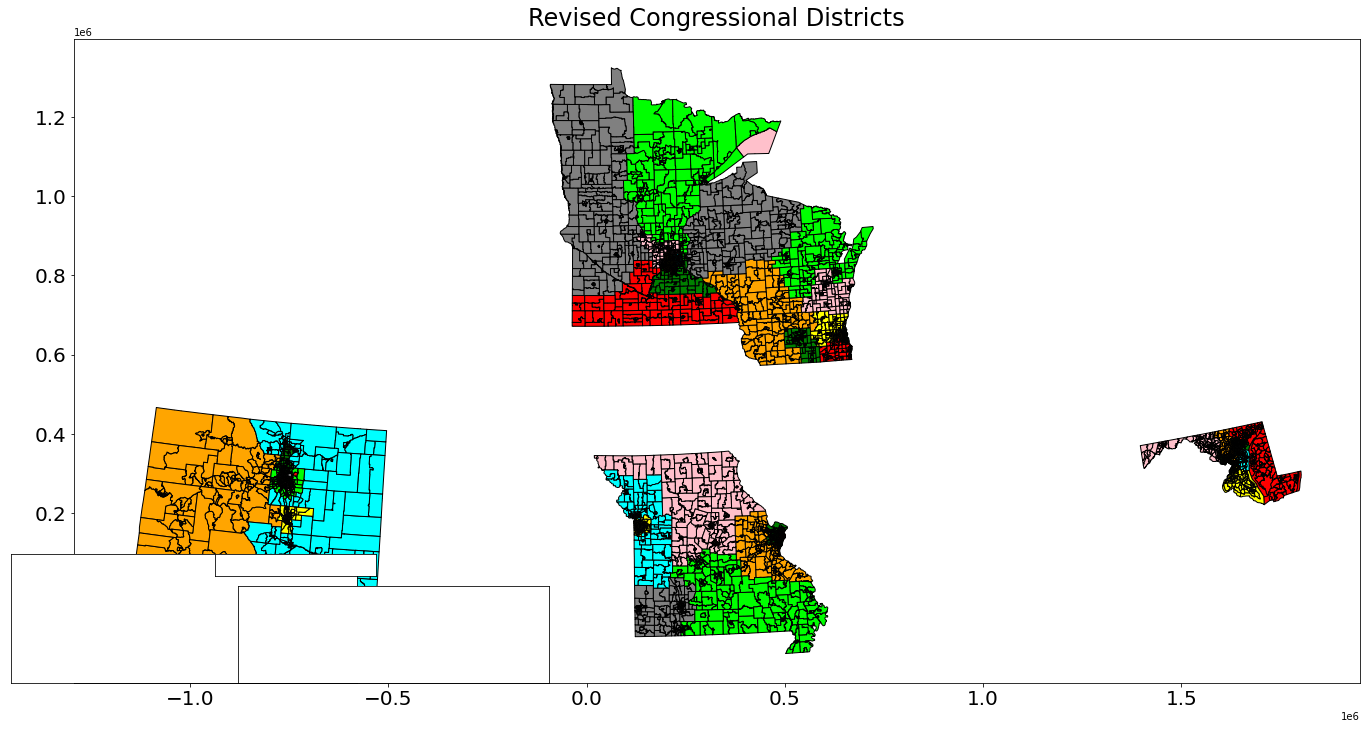

Done plotting and saving in 104 seconds!


In [23]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(new_district_list)+1):
        tract_gdf[
            (tract_gdf['STUSAB'] == this_state) 
            & (tract_gdf['new_district'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)

ax.set_title('Revised Congressional Districts', fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)

# # # # # # print('saving figure...')
# # # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # # #plt.show()
# # # e = time.time()
# # # g += (e-s)
# # # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'AK')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(new_district_list)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'HI')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'HI') & (tract_gdf['new_district'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

### Check RI
# ax.set_xlim([1.9e6, 2.2e6])
# ax.set_ylim([.7e6, .9e6])

for thisax in [ak_inset_ax, aleutians_inset_ax, hi_inset_ax]: #[ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()
# print('saving figure...')
# fig.savefig(script_dir+'new-districts-1-to-7.jpg', format='jpg', dpi=300, bbox_inches='tight')
e = time.time()
g += (e-s)
print('Done plotting and saving in {0:,.0f} seconds!'.format(e-s))


In [24]:
s = time.time()
tract_gdf['new_district'].to_csv(script_dir+'new-districts-8.csv')
e = time.time()
g += (e-s)
print('Classified and saved {0:,.0f} in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format( np.floor(g/60), g%60))

Classified and saved 7,623 in 0 minutes 0 seconds!


TOTAL TIME: 18 minutes 58 seconds!


# WISCONSIN

In [25]:
# s = time.time()
# this_state = 'WI'
# examine_duplicates = False

# nDistricts = these_states_dict[this_state]['seats_new']
# state_target = these_states_dict[this_state]['target']

# print('getting from backup...')
# tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

# county_mapper_df = pandas.DataFrame(data=[    
# ['Racine County',1],
#     ['Kenosha County',1],
#     ['Walworth County',1],
    
    
# ['Washington County',5],
#     ['Ozaukee County',5],

    
# ['Rock County',2], 
#     ['Dane County',2], 
    
    
    
# ['Brown County',8], 
#     ['Kewaunee County',8], 
#     ['Door County',8], 
#     ['Oconto County',8],
#     ['Shawano County',8], 
#     ['Marinette County',8], 
#     ['Menominee County',8],
#     ['Waupaca County',8], 
#     ['Langlade County',8], 
#     ['Forest County',8], 
#     ['Florence County',8],    
#     ['Waushara County',8], 
#     ['Portage County',8], 
    
    
# ['Winnebago County',6], 
#     ['Calumet County',6], 
#     ['Outagamie County',6],    
#     ['Manitowoc County',6], 
#     ['Fond du Lac County',6], 
#     ['Sheboygan County',6],
#     ['Green Lake County',6],
    

    
# ['Chippewa County',7],
#     ['Eau Claire County',7],   
#     ['Dunn County',7], 
#     ['St. Croix County',7], 
#     ['Polk County',7], 
#     ['Barron County',7], 
#     ['Rusk County',7], 
#     ['Burnett County',7], 
#     ['Washburn County',7], 
#     ['Douglas County',7],
#     ['Pierce County',7], 
#     ['Taylor County',7], 
#     ['Bayfield County',7], 
#     ['Ashland County',7], 
#     ['Iron County',7], 
#     ['Sawyer County',7], 
#     ['Price County',7], 
#     ['Vilas County',7], 
#     ['Oneida County',7], 
#     ['Lincoln County',7],
    
# ], columns=['COUNTY_NAME', 'new_district_by_county'])
# county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

# place_mapper_df = pandas.DataFrame(data=[
# ['Milwaukee',4], 
#     ['West Milwaukee',4], 
#     ['Shorewood',4], 
#     ['Whitefish Bay',4], 
#     ['Glendale',4], 
#     ['Fox Point',4], 
#     ['Bayside',4], 
#     ['River Hills',4], 
#     ['Brown Deer',4],
#     ['Cudahy',4], 
#     ['St. Francis',4], 
#     ['South Milwaukee',4], 
#     ['Greenfield',4], 

    
# ['Hales Corners',1], 
#     ['Greendale',1], 
#     ['Franklin',1], 
#     ['Oak Creek',1], 
#     ['Muskego',1], 
#     ['Big Bend',1], 
#     ['Mukwonago',1],
#     ['West Allis',1], 
#     ['New Berlin',1],
    
    
    
# ['Wauwatosa',5],
#     ['Rome',5], 
#     ['Watertown',5], 
#     ['Kekoskee',5], 
#     ['Beaver Dam',5], 
#     ['Lake Mills',5], 
#     ['Jefferson',5], 
#     ['Fort Atkinson',5], 
#     ['Mayville',5],
    
    
    
# ['Wausau',8], 
#     ['Rothschild',8], 
#     ['Weston',8], 
#     ['Kronenwetter',8], 
#     ['Rib Mountain',8], 
#     ['Mosinee',8], 
#     ['Schofield',8], 
#     ['Maine',8],
    
 
# ], columns=['NAME', 'new_district_by_place'])


# print('Assigning districts by county...')


# tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


# this_state_places = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]

# if (len(this_state_places[
#     (this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist())) 
#     & (this_state_places['NAME'].duplicated() == True)]) > 0):
#     print('DANGER: list of selected places includes duplicate place names:')
#     print('\n')
#     duplicated_name_list = this_state_places[(this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist()))  & (this_state_places['NAME'].duplicated() == True)]['NAME'].tolist()
#     for this_duplicated_name in duplicated_name_list:
#         print('----- {0:} -----'.format(this_duplicated_name))
#         if (examine_duplicates):
#             all_duplicated_tracts_to_show = []
#             for ix, thisrow in this_state_places[(this_state_places['NAME'] == this_duplicated_name)].iterrows():
#                 print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))
#                 included_tracts = []
#                 for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
#                     print('\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
#                     for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
#                         this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
#                         this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
#                         this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
#                         if (this_tract_intersection_pct >= desired_pct_area_overlap):
#                             print('\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
#                             included_tracts.append(kx)
#                 print('\t\t{0:} (GEOID = {1:}) includes {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAMELSAD'], ix, len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
#                 print('\n')

#                 all_duplicated_tracts_to_show += included_tracts
#             tract_gdf[tract_gdf.index.isin(all_duplicated_tracts_to_show)].plot()

# #print('\n')
# #place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicate_place_names_list)].index, axis=0)
# # print('Selecting the correct place from the duplicates...')
# # print('\t{0:} (GEOID == {1:})'.format('St. Anthony (Minneapolis area)', '1600000US2756680'))
# #place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'St. Anthony') & (place_mapper_gdf.index != '1600000US2756680')].index, axis=0)
# #print('\n')



# #print('\n')
# for i in range(1, nDistricts+1):
#     print('Looking for tracts related to places in District {0:.0f}...'.format(i))
#     tracts_here = []
#     this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
#     tracts_within = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.within(this_district_places_geo))
#     ].index.tolist()
#     if (len(tracts_within) > 0):
#         print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
#     tracts_here += tracts_within
    
#     intersecting_tracts = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.intersects(this_district_places_geo))
#         & ~(tract_gdf.index.isin(tracts_within))
#     ].index.tolist()
#     if (len(intersecting_tracts) > 0):
#         print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
#     cnt = 0
#     for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
#         cnt += 1
#         if (np.mod(cnt,50) == 1):            
#             print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
#         tract_area_sq_deg = thisrow.geometry.area
#         overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
#         overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
#         if (overlap_pct >= desired_pct_area_overlap):
#             tracts_here.append(ix)
#             #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

#     tract_gdf.loc[tracts_here, 'new_district'] = i

    

# print('Assigning districts by tract number...')
# tract_gdf.loc[['1400000US55079018100', '1400000US55079018200', '1400000US55079980000'], 'new_district'] = 4     # Coast of Milwaukee
# tract_gdf.loc[['1400000US55079120300'], 'new_district'] = 4     # N of Greenfield within Milwaukee




# tract_gdf.loc[['1400000US55133201504'], 'new_district'] = 1    # NE end of Muskego 
# tract_gdf.loc[['1400000US55133202001', '1400000US55133202002'], 'new_district'] = 1    # Between Muskego and Mukwonago
# tract_gdf.loc[['1400000US55133203901', '1400000US55133203802'], 'new_district'] = 1   #Mukwonago
# tract_gdf.loc[['1400000US55133202103', '1400000US55133204002'], 'new_district'] = 1  # SW Waukesha County



# #### Rest of Waukesha County is District 5
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Waukesha County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 5

# tract_gdf.loc[['1400000US55027960100', '1400000US55027960200', '1400000US55027960400', '1400000US55027961100', '1400000US55027961400', '1400000US55027960300'], 'new_district'] = 5  # N Dodge County
# tract_gdf.loc[['1400000US55027961500', '1400000US55027961600', '1400000US55027961700'], 'new_district'] = 5  # S Dodge County
# tract_gdf.loc[['1400000US55055100500', '1400000US55055100700', '1400000US55055100800', '1400000US55055101000', '1400000US55055101701', '1400000US55055101702', '1400000US55055100400'], 'new_district'] = 5  # N Jefferson County
# tract_gdf.loc[['1400000US55055100900', '1400000US55055101202', '1400000US55055101300', '1400000US55055101600', '1400000US55055100601'], 'new_district'] = 5  # S Jefferson County


    

    
# #### Rest of Jefferson County is District 2
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Jefferson County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

    

    
    
# tract_gdf.loc[['1400000US55073001105', '1400000US55073001401', '1400000US55073001402', '1400000US55073001500', '1400000US55073001600', '1400000US55073001700'], 'new_district'] = 8      # E of Wausau
# tract_gdf.loc[['1400000US55073001202', '1400000US55073001800', '1400000US55073001900'], 'new_district'] = 8      # S of Wausau



# tract_gdf.loc[['1400000US55019950100', '1400000US55019950200', '1400000US55019950300'], 'new_district'] = 7     #  N Clark County
# tract_gdf.loc[['1400000US55073002200', '1400000US55073002301', '1400000US55073002302'], 'new_district'] = 7     #  NW Marathon County



# ## print('All the rest are district 3...')
# tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 3


# print('Except ocean tracts...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan


# e = time.time()
# g += (e-s)

# print('\n')
# print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')

# # print(state_target)    
# for i in range(1, these_states_dict[this_state]['seats_new']+1): 
#     if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
#             i, 
#             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
#             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
#             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
# print('Done!')




In [26]:
# this_state = 'WI'

# show_water = False
# show_roads = False
# show_small_roads = False
# label_tracts = False

# show_cbsa = False
# label_cbsa = False

# show_places = False
# label_places = False

# show_counties = True
# label_counties = False

# print_ready = False
# assign_to_district = 8

# the_label_size = 20
# the_annotation_size = 18
# the_line_width = 1
# the_line_width_wide = 8
# the_legend_size = 18
# the_title_size = 24

# bounds_counties = []

# if (len(bounds_counties) > 0):
#     xlimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[3]]
# else:
#     xlimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).geometry.tolist()).bounds[3]]


    


# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

# print('xspan = {0:,.2f} km'.format(xspan/1000))
# print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
# print('\n')

# # fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
# ax.set_aspect('equal')



# print('plotting tracts...')

# #. base layer
# legend_list = []
# for i in range(-1,these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
#         #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
#         tract_gdf[
#             (tract_gdf['STUSAB'] == this_state) 
#             & (tract_gdf['new_district'] == i)
#         ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)        
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

# tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull())].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='gray', lw=the_line_width)




# if (label_tracts):
#     print('labeling tracts...')
#     print_count = 0
#     for ix, thisrow in tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (((tract_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((tract_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1])))) & ((tract_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((tract_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1]))))
#           )
#         & (tract_gdf['new_district'].isnull())
#         #& (tract_gdf['new_district'] == 2)

#     ].to_crs(main_map_crs).sort_values(by=['COUNTY_NAME', 'census_tract']).iterrows():

#         if (not(print_ready)):
#             print('{0:}-{1:}:\t{2:}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], ix))
#             #print('{0:}:\t{1:}'.format(thisrow['census_tract'], ix))
#         else:
#             print_count += 1
#             if (print_count == 1):
#                 printme = "tract_gdf.loc[["
#             printme += "'{0:}'".format(ix)
#             if (np.mod(print_count,3) == 0):
#                 if (np.mod(print_count,9) == 0):
#                     printme += "], 'new_district'] = {0:.0f}".format(assign_to_district)
#                     print(printme)
#                     printme = ''
#                     print_count = 0
#                 else:
#                     printme += ",\n\t"
#             else:
#                 printme += ","
#         #annotator = '{0:}-{1:}\n{2:,.0f}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], geo_df.loc[ix]['POP100'])
#         annotator = '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
#         centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='gray', backgroundcolor='white', ha='center', va='center', 
#                     fontsize=the_annotation_size)




# if (show_places):
#     print('plotting places...')
#     place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
#     ].to_crs(main_map_crs).plot(ax=ax, edgecolor='purple', lw=the_line_width_wide, color='none')

# if (label_places):
#     print('labeling places...')
#     for ix, thisrow in place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])& (((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x <= xlimits[1]))))& ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((place_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y <= ylimits[1])))))
#     ].to_crs(main_map_crs).iterrows():
#         if (thisrow['NAME'] not in ['Rib Mountain']): 
#             annotator = thisrow['NAME'].replace(' ','\n')
#             centerpoint = [thisrow.geometry.centroid.x, thisrow.geometry.centroid.y]
#             ax.annotate(annotator, centerpoint, 
#                         color='black', backgroundcolor='white', ha='center', va='center', 
#                         fontsize=the_annotation_size)

# if (show_water):
#     print('plotting water areas...')
#     water_gdf[water_gdf['STUSAB'] == this_state].to_crs(main_map_crs).plot(ax=ax, color='blue')

    
# # # # if (show_roads):
# # # #     print('plotting roads...')
# # # #     if (show_small_roads):
# # # #         print('\tsmall...')
# # # #         roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color='black', linewidth=0.1)
# # # #     print('\tlarge...')
# # # #     roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=0.25) 
# # # #     roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=0.5) 
# # # #     roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=0.75)     
# # # #     roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=1) 

# if (show_counties):
#     print('\n')
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     else:
#         county_gdf[
#             (county_gdf['STATEFP'] == state_codes_df[
#                 state_codes_df['STUSAB'] == this_state
#             ]['STATE'].values[0]
#             )].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width)

#     state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
                    
# if (label_counties):
#     print('labeling counties...')
#     if (len(bounds_counties) == 0):
#         bounds_counties = tract_gdf['COUNTY_NAME'].apply(lambda x: x[:x.find(" County")]).drop_duplicates().tolist()
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])
#         & (county_gdf['NAME'].isin(bounds_counties))
# #        & (((county_gdf.to_crs(main_map_crs).centroid.x >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).centroid.x <= xlimits[1])) & ((county_gdf.to_crs(main_map_crs).centroid.y >= ylimits[0]) & (county_gdf.to_crs(main_map_crs).centroid.y <= ylimits[1])))
#     ].sort_values(by='NAME').to_crs(main_map_crs).iterrows():
#         if (thisrow['NAME'] != 'Yellow Medicine'):
#             annotator = thisrow['NAME'].replace(' ', '\n')
#             centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#             ax.annotate(annotator, centerpoint, color='gray', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size)

# if (show_cbsa):
#     print('\n')
#     print('plotting CBSAs...')
#     cbsa_gdf[
#         (cbsa_gdf['NAME'].apply(lambda x: this_state in x))
#     ].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='orange', linewidth=4)
    
# if (label_cbsa):
#     print('labeling CBSAs...')
#     for ix, thisrow in cbsa_gdf[(cbsa_gdf['NAME'].apply(lambda x: this_state in x))].to_crs(main_map_crs).iterrows():
#         annotator = thisrow['NAME']
#         centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#         ax.annotate(annotator, centerpoint, color='orange', backgroundcolor='white', ha='center', va='center', fontsize=the_annotation_size)


# plt.xlim(xlimits)
# plt.ylim(ylimits)

# #ax.set_xticks(np.arange(xlimits[0], xlimits[1], xspan/10))#, fontsize=the_label_size)
# #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size)

# #ax.set_yticks(np.arange(27.8, 28.8, 0.025))
# ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size)

# ax.legend(handles=legend_list, fontsize=the_legend_size, loc='upper right')


# plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
#     this_state, 
#     these_states_dict[this_state]['seats_new']
# ), fontsize=the_title_size)



# # plt.show()
# # print('\n')
# for i in range(1, these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
#         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, 
#                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
#                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
#                                                                                             tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target)
#              )
# plt.show()




    


In [27]:

    
# NAME	POP100
# GEOID		
# 33340	Milwaukee-Waukesha, WI	1574731.0
# 31540	Madison, WI	680796.0
# 24580	Green Bay, WI	328268.0
# 11540	Appleton, WI	243147.0
# 39540	Racine, WI	197727.0
# 20740	Eau Claire, WI	172007.0
# 36780	Oshkosh-Neenah, WI	171730.0
# 16980	Chicago-Naperville-Elgin, IL-IN-WI	169151.0
# 48140	Wausau-Weston, WI	166428.0
# 27500	Janesville-Beloit, WI	163687.0
# 33460	Minneapolis-St. Paul-Bloomington, MN-WI	135748.0
# 29100	La Crosse-Onalaska, WI-MN	120784.0
# 43100	Sheboygan, WI	118034.0
# 48580	Whitewater, WI	106478.0
# 22540	Fond du Lac, WI	104154.0

In [28]:
############## COLORADO ############

#### Denver area
# xlimits = [-810000,-720000]
# ylimits = [240000,340000]

#### E city of Denver
# xlimits = [-762000,-750000]
# ylimits = [278000,293000]

#### E of Denver, close in 
# xlimits = [-756000,-747400]
# ylimits = [272000,290000]


#### SSE of Denver
# xlimits = [-775000,-742000]
# ylimits = [261000,281000]


# E of Denver (suburban)
# xlimits = [-758000,-715000]
# ylimits = [260000,295000]

#### W of Denver
# xlimits = [-794000,-766000]
# ylimits = [272000, 308000]


#### NNW of Denver
# xlimits = [-786000,-740000]
# ylimits = [302000, 314000]


#### S of Denver
# xlimits = [-780000,-735000]
# ylimits = [240000,265000]


#### N of Denver
# xlimits = [-770000,-730000]
# ylimits = [300000,325000]


#### Boulder to Fort Collins
# xlimits = [-800000,-730000]
# ylimits = [310000,385000]



############## MINNESOTA ############

# ### Minneapolis in Hennepin County
# # xlimits = [195000,220000]
# # ylimits = [825000,855000]





############## MISSOURI ############

### St. Louis City immediate vicinity North
# xlimits = [482000,502000]
# ylimits = [144000,162000]


### Dense area S of Ferguson
# xlimits = [485000,495000]
# ylimits = [146600,152200]

### St. Louis City immediate vicinity South
# xlimits = [480000,502000]
# ylimits = [120000,144000]


### Dardenne Prairie
# xlimits = [455000,468000]
# ylimits = [145000,155000]

### Murphy/Arnold/Kimmswick
# xlimits = [472000,488000]
# ylimits = [106000,128000]




############## WISCONSIN ############

# #### Milwaukee County
# xlimits = [635000,665000]
# ylimits = [620000,665000]
